<a href="https://colab.research.google.com/github/easyri/paintings-and-stuff/blob/master/pretrained_test/flikr_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Painting captioning with NIC model trained on flikr8 dataset

(see examples at the end of the notebook)

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os, glob, cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import resnet50
from keras.models import Model
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.layers import Flatten, Input
import keras 
from keras import layers
import torch
from torch import nn
from collections import OrderedDict
import argparse
import os
from torchvision import transforms, utils, datasets, models
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torch import optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import time
import glob
import copy
import shutil
import sys
from matplotlib.ticker import MaxNLocator
from keras.applications.vgg16 import VGG16
from keras.layers import Reshape, Concatenate
from collections import defaultdict
import string
from os import listdir
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from pickle import dump
from sklearn.model_selection import train_test_split
from pickle import load, dump
import argparse
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Reshape, Concatenate

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

EMBEDDING_DIM = 256

lstm_layers = 1
dropout_rate = 0.5
learning_rate = 0.001

In [ ]:
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text

# load a pre-defined list of photo identifiers
def load_set(filename):
  doc = load_doc(filename)
  dataset = list()
  # process line by line
  for line in doc.split('\n'):
    # skip empty lines
    if len(line) < 1:
      continue
    # get the image identifier
    identifier = line.split('.')[0]
    dataset.append(identifier)
  return set(dataset)



def load_photo_arrays(filename, dataset):
  # load all features
  all = load(open(filename, 'rb'))
  # filter features
  features = {k: all[k] for k in dataset}
  return features

Load flikr8 images and get features with vgg16

In [ ]:
images = load(open('/content/drive/My Drive/paintings/flikr_arrays.pkl', 'rb'))

8091


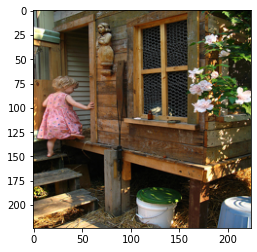

In [ ]:
%matplotlib inline
imshow(images[list(images.keys())[0]])
print(len(list(images.keys())))

In [ ]:

vgg16_model = keras.applications.vgg16.VGG16()
custom_model = keras.Sequential()

for layer in vgg16_model.layers[:-1]: 
    custom_model.add(layer)    

# Freeze the layers 
for layer in custom_model.layers:
    layer.trainable = False


# re-structure the model
custom_model = Model(inputs=custom_model.inputs, outputs=custom_model.layers[-1].output)

features = {}
for id, image in images.items():
  image = np.expand_dims(image, axis=0)
  image = preprocess_input(image)
  feature = custom_model.predict(image, verbose=0)
  features[id] = feature
  # print(feature.shape)

print(len(features))
dump(features, open('/content/drive/My Drive/paintings/flikr_features.pkl', 'wb'))

8091


load flikr8 captions and prepare for training

In [ ]:

train_names = '/content/drive/My Drive/paintings/Flickr_8k.trainImages.txt'
test_names = '/content/drive/My Drive/paintings/Flickr_8k.devImages.txt'
train = load_set(train_names)
test = load_set(test_names)
train_features = load_photo_arrays('/content/drive/My Drive/paintings/flikr_features.pkl', train)
test_features = load_photo_arrays('/content/drive/My Drive/paintings/flikr_features.pkl', test)
print(len(train_features.keys()))
print(len(test_features.keys()))

6000
1000


In [ ]:
print(train_features['3532028205_9ddd7599f8'].shape)

(1, 4096)


In [ ]:
# calculate the length of the description with the most words
def max_length(descriptions):
  lines = to_lines(descriptions)
  return max(len(d.split()) for d in lines)


  # convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
  all_desc = list()
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc

  
def load_clean_descriptions(filename, dataset):
  # load document
  doc = load_doc(filename)
  descriptions = dict()
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    # split id from description
    image_id, image_desc = tokens[0], tokens[1:]
    # skip images not in the set
    if image_id in dataset:
      # create list
      if image_id not in descriptions:
        descriptions[image_id] = list()
      # wrap description in tokens
      desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
      # store
      descriptions[image_id].append(desc)
  return descriptions


In [ ]:
tokenizer = load(open('/content/drive/My Drive/paintings/flikr_tokenizer.pkl', 'rb'))
index_word = load(open('/content/drive/My Drive/paintings/flikr_index_word.pkl', 'rb'))
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7579


In [ ]:
train_descriptions = load_clean_descriptions('/content/drive/My Drive/paintings/flikr_descr.txt', train)
test_descriptions = load_clean_descriptions('/content/drive/My Drive/paintings/flikr_descr.txt', test)
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


define and train model

In [ ]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo):
  vocab_size = len(tokenizer.word_index) + 1

  X1, X2, y = [], [], []
  # walk through each description for the image
  for desc in desc_list:
    # encode the sequence
    seq = tokenizer.texts_to_sequences([desc])[0]
    # split one sequence into multiple X,y pairs
    for i in range(1, len(seq)):
      # split into input and output pair
      in_seq, out_seq = seq[:i], seq[i]
      # pad input sequence
      in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
      # encode output sequence
      out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
      # store
      X1.append(photo)
      X2.append(in_seq)
      y.append(out_seq)
  return np.array(X1), np.array(X2), np.array(y)

# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length, n_step = 1):
  # loop for ever over images
  while True:
    # loop over photo identifiers in the dataset
    keys = list(descriptions.keys())
    for i in range(0, len(keys), n_step):
      Ximages, XSeq, y = list(), list(),list()
      for j in range(i, min(len(keys), i+n_step)):
        image_id = keys[j]
        # retrieve the photo feature
        photo = photos[image_id][0]
        desc_list = descriptions[image_id]
        # print(desc_list)
        in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
        # print(in_img, in_seq, out_word)
        for k in range(len(in_img)):
          Ximages.append(in_img[k])
          XSeq.append(in_seq[k])
          y.append(out_word[k])
      yield ([np.array(Ximages), np.array(XSeq)], np.array(y)) # ебаные скобки


def categorical_crossentropy_from_logits(y_true, y_pred):
  y_true = y_true[:, :-1, :]  # Discard the last timestep
  y_pred = y_pred[:, :-1, :]  # Discard the last timestep
  loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true,
                                                 logits=y_pred)
  return loss

def categorical_accuracy_with_variable_timestep(y_true, y_pred):
  y_true = y_true[:, :-1, :]  # Discard the last timestep
  y_pred = y_pred[:, :-1, :]  # Discard the last timestep

  # Flatten the timestep dimension
  shape = tf.shape(y_true)
  y_true = tf.reshape(y_true, [-1, shape[-1]])
  y_pred = tf.reshape(y_pred, [-1, shape[-1]])

  # Discard rows that are all zeros as they represent padding words.
  is_zero_y_true = tf.equal(y_true, 0)
  is_zero_row_y_true = tf.reduce_all(is_zero_y_true, axis=-1)
  y_true = tf.boolean_mask(y_true, ~is_zero_row_y_true)
  y_pred = tf.boolean_mask(y_pred, ~is_zero_row_y_true)

  accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_true, axis=1),
                                              tf.argmax(y_pred, axis=1)),
                                    dtype=tf.float32))
  return accuracy

# define the captioning model
def define_model(vocab_size, max_length):
  # feature extractor (encoder)
  inputs1 = Input(shape=(4096,))
  print(inputs1.shape)
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(EMBEDDING_DIM, activation='relu')(fe1)
  fe3 = RepeatVector(max_length)(fe2)

  # embedding
  inputs2 = Input(shape=(max_length,))
  print(inputs2.shape)
  emb2 = Embedding(vocab_size, EMBEDDING_DIM, mask_zero=True)(inputs2)

  # merge inputs
  merged = concatenate([fe3, emb2])
  # language model (decoder)
  lm2 = LSTM(500, return_sequences=False)(merged)
  print(lm2.shape)
  #lm3 = Dense(500, activation='relu')(lm2)
  outputs = Dense(vocab_size, activation='softmax')(lm2)

  # tie it together [image, seq] [word]
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  plot_model(model, show_shapes=True, to_file='model.png')
  return model

In [ ]:
model = define_model(vocab_size, max_length)

(None, 4096)
(None, 34)
(None, 500)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 4096)         0           input_5[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 256)          1048832     dropout_2[0][0]                  
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 34)]         0                                            
________________________________________________________

In [ ]:
  # generate model
model = define_model(vocab_size, max_length)


  # define checkpoint callback
filepath = '/content/drive/My Drive/paintings/flikr/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,save_freq='epoch',
              save_best_only=True, save_weights_only=False, mode='min')

steps = len(train_descriptions)
val_steps = len(test_descriptions)
  # create the data generator
train_generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
val_generator = data_generator(test_descriptions, test_features, tokenizer, max_length)

  # fit model
model.fit_generator(train_generator, epochs=20, steps_per_epoch=steps, verbose=1,
      callbacks=[checkpoint], validation_data=val_generator, validation_steps=val_steps)

try:
    model.save('/content/drive/My Drive/paintings/flikr/flikr_wholeModel.h5', overwrite=True)
    model.save_weights('/content/drive/My Drive/paintings/flikr/flikr_weights.h5',overwrite=True)
except:
    print("Error in saving model.")
print("Training complete...\n")


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_3[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          1048832     dropout_1[0][0]                  
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 34)]         0                                            
_______________________________________________________________________________________

continue training after reloading

In [ ]:
load_mod = load_model('/content/drive/MyDrive/paintings/flikr/model-ep009-loss2.175-val_loss4.502.h5')

In [ ]:
filepath = '/content/drive/My Drive/paintings/flikr/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,save_freq='epoch',
              save_best_only=False, save_weights_only=False, mode='min')

steps = len(train_descriptions)
val_steps = len(test_descriptions)
  # create the data generator
train_generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
val_generator = data_generator(test_descriptions, test_features, tokenizer, max_length)

  # fit model
load_mod.fit(train_generator, epochs=17, steps_per_epoch=steps, verbose=1,
      callbacks=[checkpoint], validation_data=val_generator, validation_steps=val_steps)

try:
    load_mod.save('/content/drive/My Drive/paintings/flikr/flikr_wholeModel.h5', overwrite=True)
    load_mod.save_weights('/content/drive/My Drive/paintings/flikr/flikr_weights.h5',overwrite=True)
except:
    print("Error in saving model.")
print("Training complete...\n")

Epoch 1/17
6000/6000 [==============================] - ETA: 0s - loss: 3.0451 - accuracy: 0.3278
Epoch 00001: saving model to /content/drive/My Drive/paintings/flikr/model-ep001-loss3.045-val_loss3.823.h5
6000/6000 [==============================] - 4709s 785ms/step - loss: 3.0451 - accuracy: 0.3278 - val_loss: 3.8232 - val_accuracy: 0.2970
Epoch 2/17
6000/6000 [==============================] - ETA: 0s - loss: 2.8659 - accuracy: 0.3440
Epoch 00002: saving model to /content/drive/My Drive/paintings/flikr/model-ep002-loss2.866-val_loss3.884.h5
6000/6000 [==============================] - 4736s 789ms/step - loss: 2.8659 - accuracy: 0.3440 - val_loss: 3.8837 - val_accuracy: 0.2954
Epoch 3/17
6000/6000 [==============================] - ETA: 0s - loss: 2.7223 - accuracy: 0.3613
Epoch 00003: saving model to /content/drive/My Drive/paintings/flikr/model-ep003-loss2.722-val_loss3.955.h5
6000/6000 [==============================] - 4743s 790ms/step - loss: 2.7223 - accuracy: 0.3613 - val_loss

Test on wikiart paintings

In [ ]:
load_mod = load_model('/content/drive/MyDrive/paintings/flikr/model-ep009-loss2.175-val_loss4.502.h5')

In [ ]:
vgg16_model = keras.applications.vgg16.VGG16()
model = keras.Sequential()

for layer in vgg16_model.layers[:-1]: 
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
  # model.add(tf.keras.layers.Dense(2, activation='softmax'))

  # re-structure the model
vgg_model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

553467904/553467096 [==============================] - 20s 0us/step


In [ ]:
def extract_features(filename, model):
 
  # load the photo
  image = load_img(filename, target_size=(224, 224))
  # convert the image pixels to a numpy array
  image = img_to_array(image)
  # reshape data for the model
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  # prepare the image for the VGG model
  image = preprocess_input(image)
  # get features
  feature = model.predict(image, verbose=0)
  return feature

In [ ]:
photos = []
files = []
tree = os.walk('/content/drive/My Drive/paintings/wikiart/test/flikr')
for i in tree:
  files.append(i)
for file in files[0][2]:
  features = extract_features('/content/drive/My Drive/paintings/wikiart/test/flikr/' + file, vgg_model)
  photos.append((file, features))

In [ ]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, index_word, max_length, beam_size=3):

  captions = [['startseq', 0.0]]
  # seed the generation process
  in_text = 'startseq'
  # iterate over the whole length of the sequence
  for i in range(max_length):
    all_caps = []
    # expand each current candidate
    for cap in captions:
      sentence, score = cap
      # if final word is 'end' token, just add the current caption
      if sentence.split()[-1] == 'endseq':
        all_caps.append(cap)
        continue
      # integer encode input sequence
      sequence = tokenizer.texts_to_sequences([sentence])[0]
      # pad input
      sequence = pad_sequences([sequence], maxlen=max_length)
      # predict next words

      y_pred = model.predict([photo,sequence], verbose=0)[0]
     
      # convert probability to integer
      yhats = np.argsort(y_pred)[-beam_size:]

      for j in yhats:
        # map integer to word
        word = index_word.get(j)
        # print(word)
        # stop if we cannot map the word
        if word is None:
          continue
        # Add word to caption, and generate log prob
        caption = [sentence + ' ' + word, score + np.log(y_pred[j])]
        all_caps.append(caption)

    # order all candidates by score
    ordered = sorted(all_caps, key=lambda tup:tup[1], reverse=True)
    captions = ordered[:beam_size]

  return captions

In [ ]:
caps = {}
for  name, photo in photos:
  caps[name] = []
  # print(photo)
  captions = generate_desc(load_mod, tokenizer, photo, index_word, 34)
  print("name: ", name)
  for cap in captions:
      # remove start and end tokens
    seq = cap[0].split()[1:-1]
    desc = ' '.join(seq)
    caps[name].append(desc)
    print('{} [log prob: {:1.2f}]'.format(desc,cap[1]))
# print(caps)

Examples:

actual name:  medusa.jpg


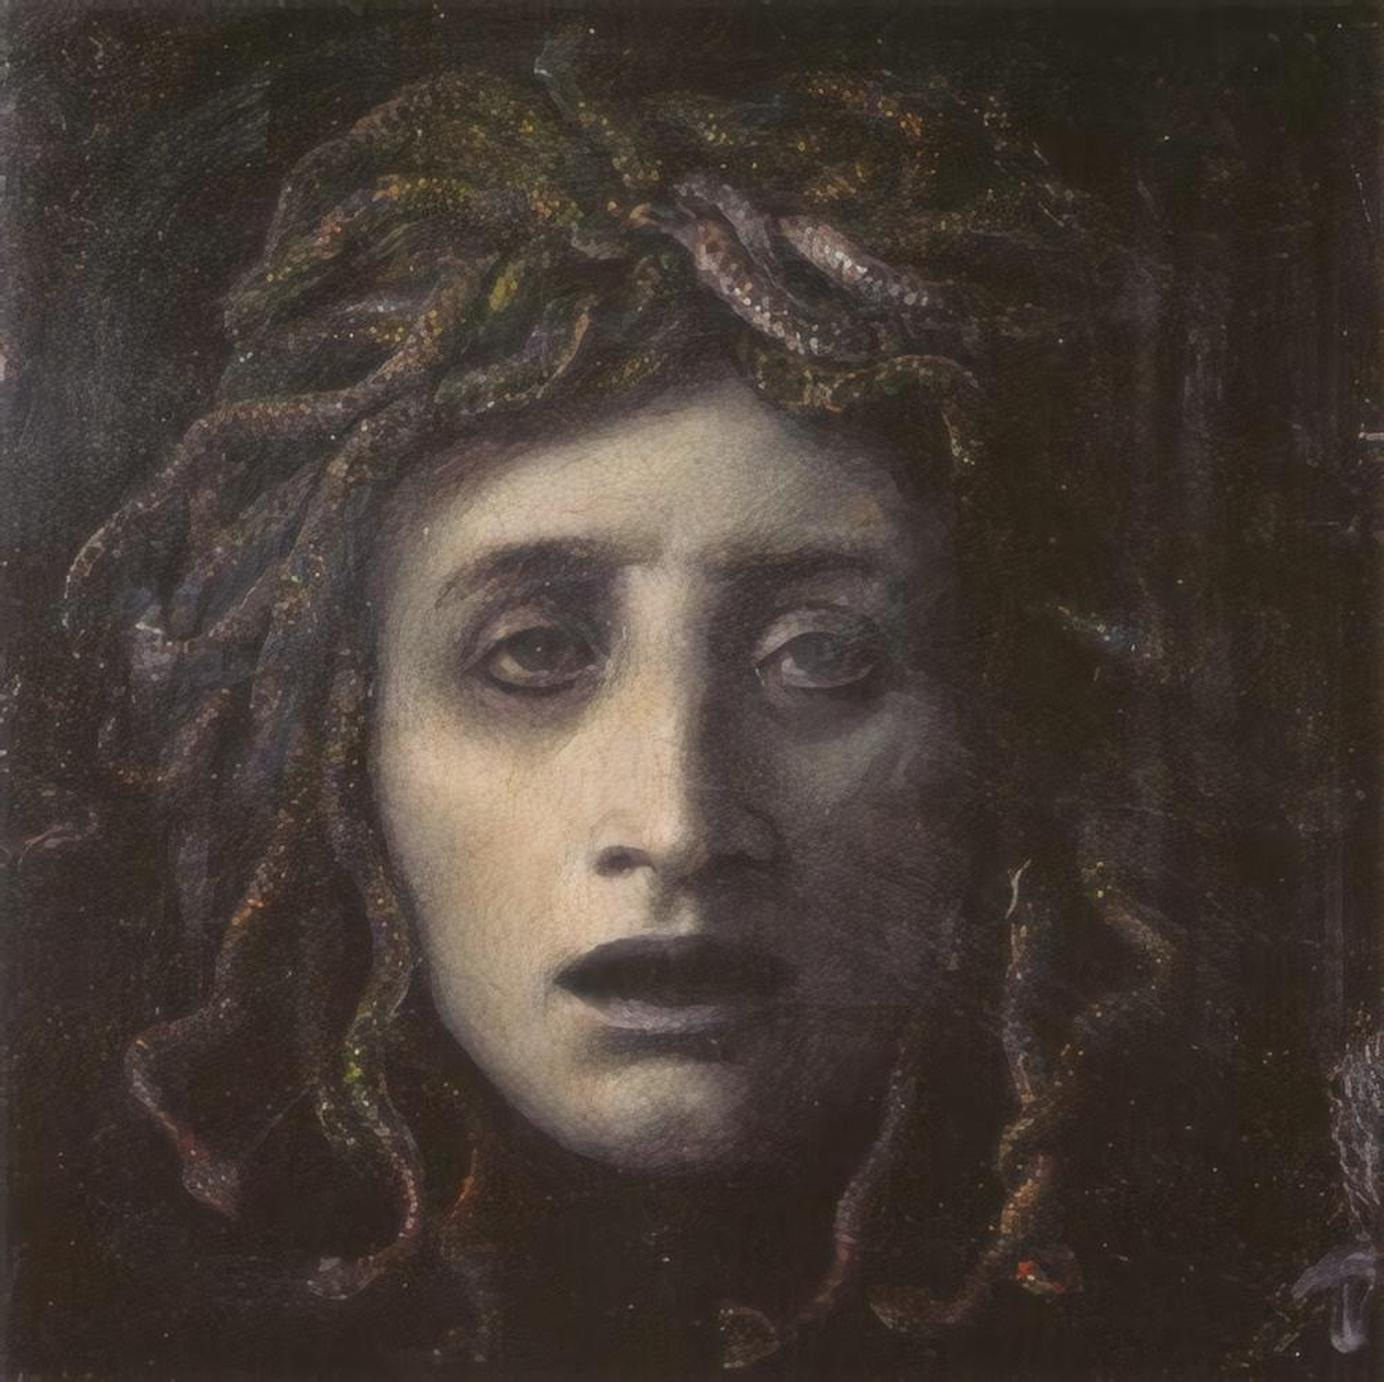

generated captions: 
the woman is wearing black leather jacket and glasses
the woman is wearing black leather jacket and glasses is smoking cigarette
the woman is wearing black leather jacket and glasses is smoking cigarette and looks down


actual name:  automaton-1979.jpg


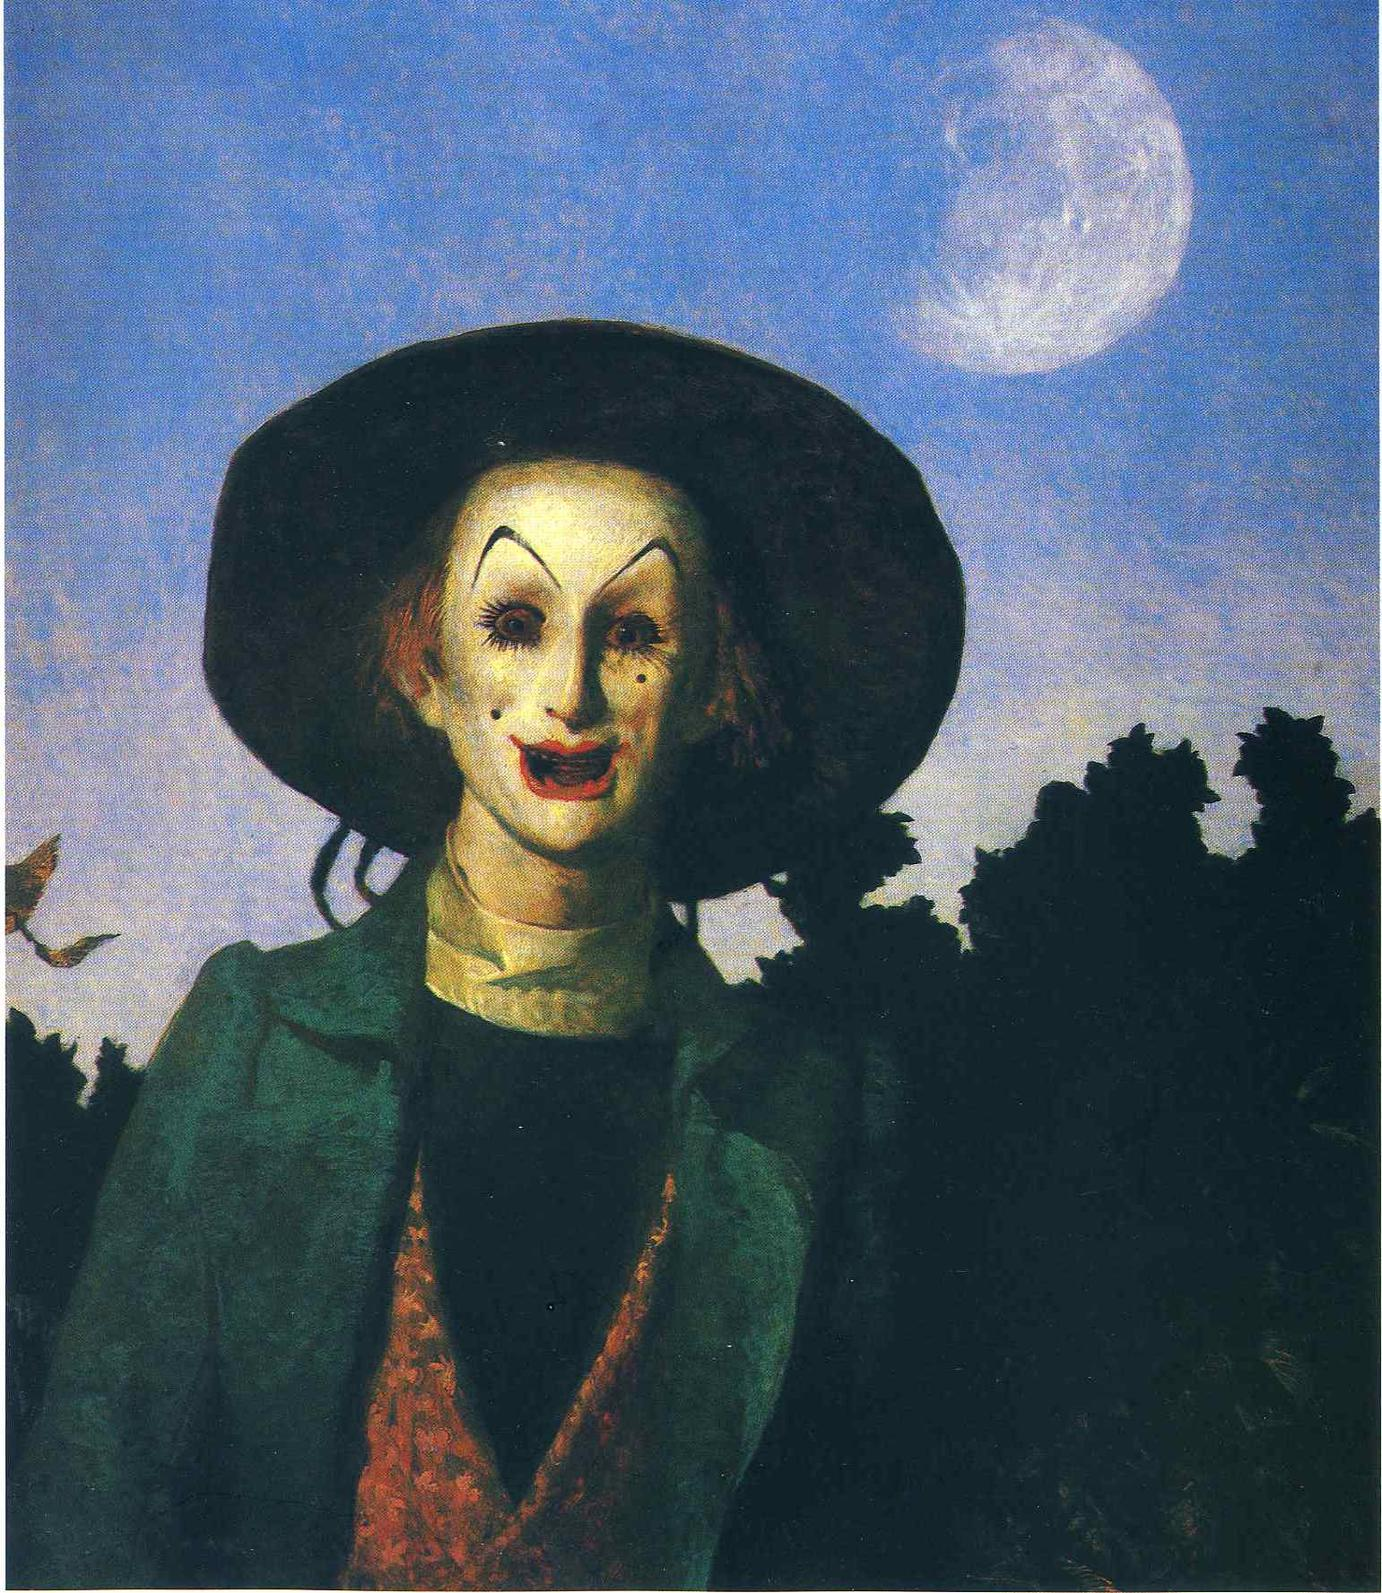

generated captions: 
two children are playing in metal sprinkler
two children are playing on the swing
two children are playing on the grass


actual name:  dog.jpg


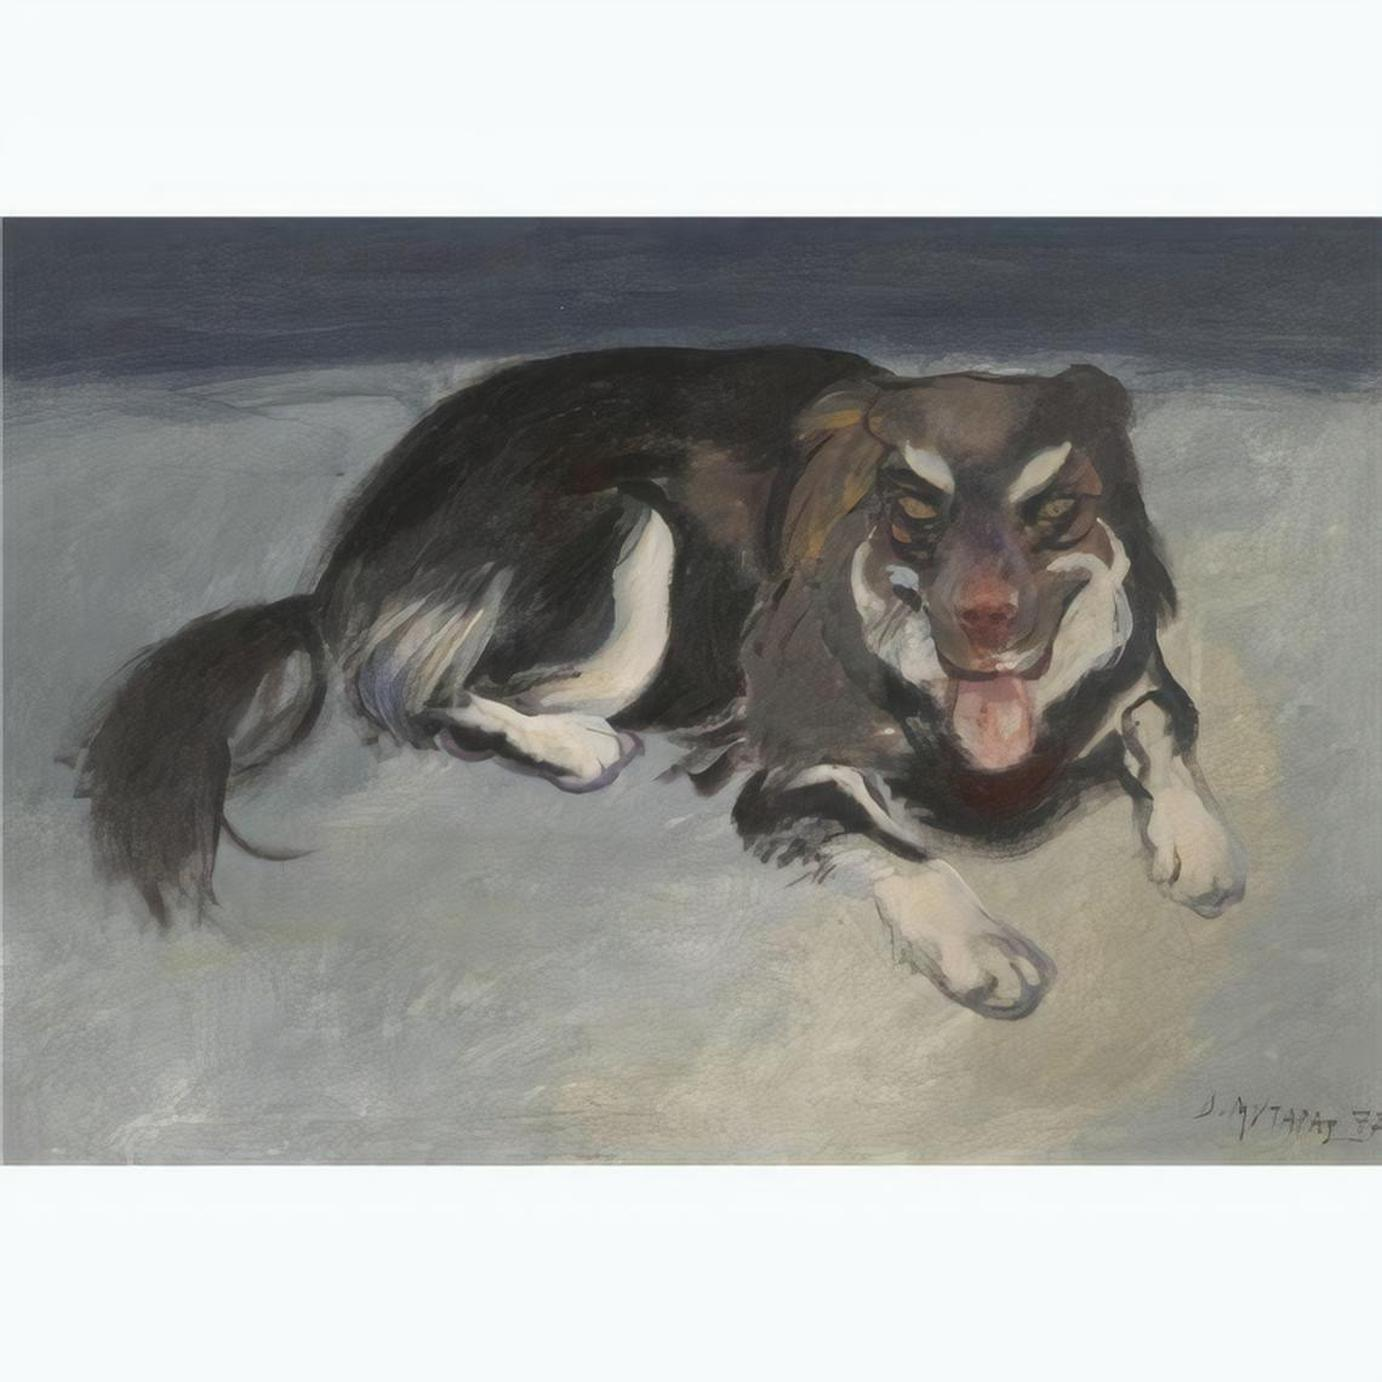

generated captions: 
black and white dog runs through the grass
black and white dog runs through field
black and white dog is running through the grass


actual name:  calf-1927.jpg


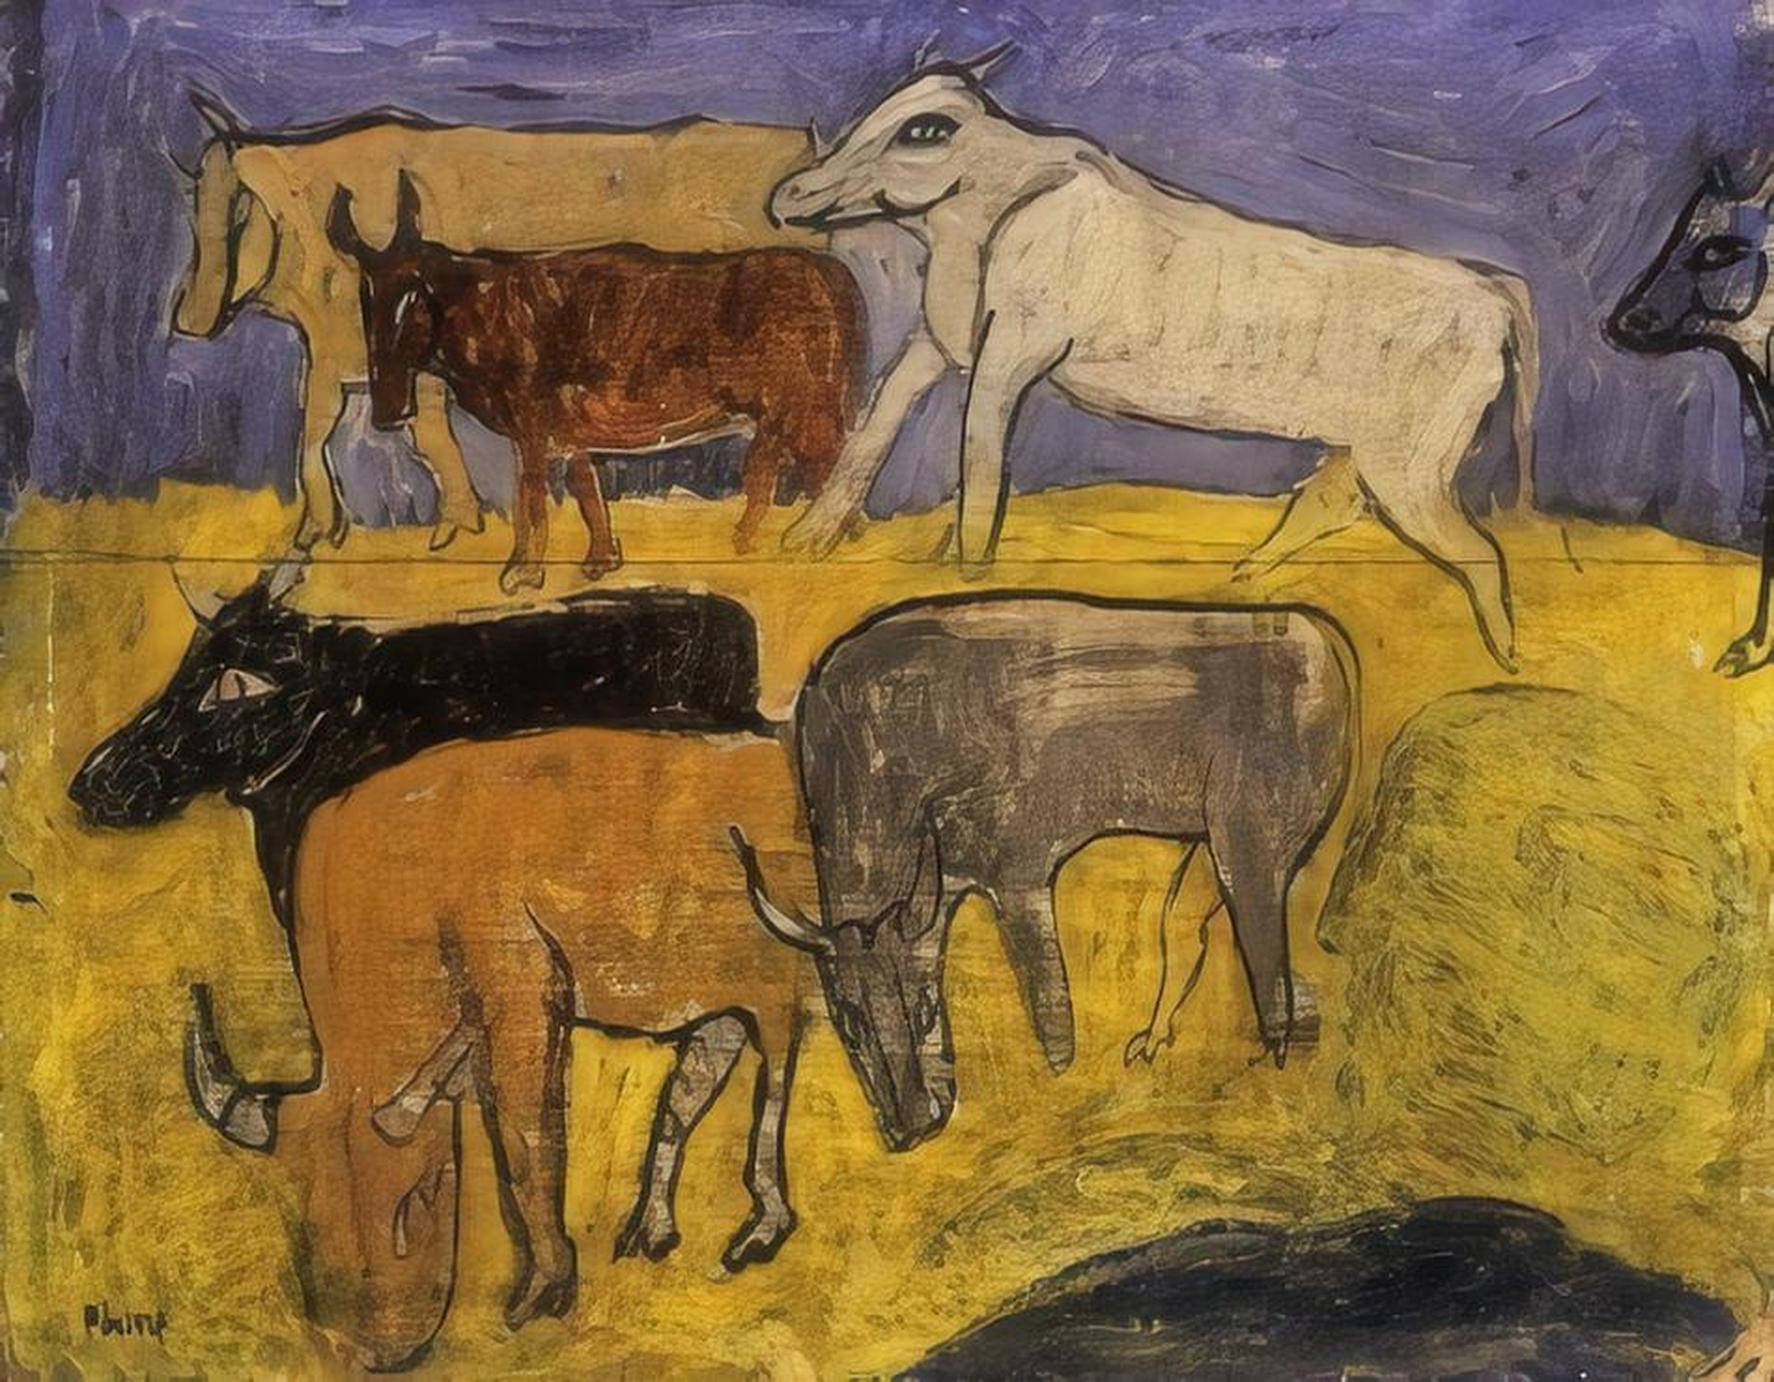

generated captions: 
group of people sit on rock path
group of people are sitting on rock path
group of people sit on the ground under an unusual tent


actual name:  melancholy.jpg


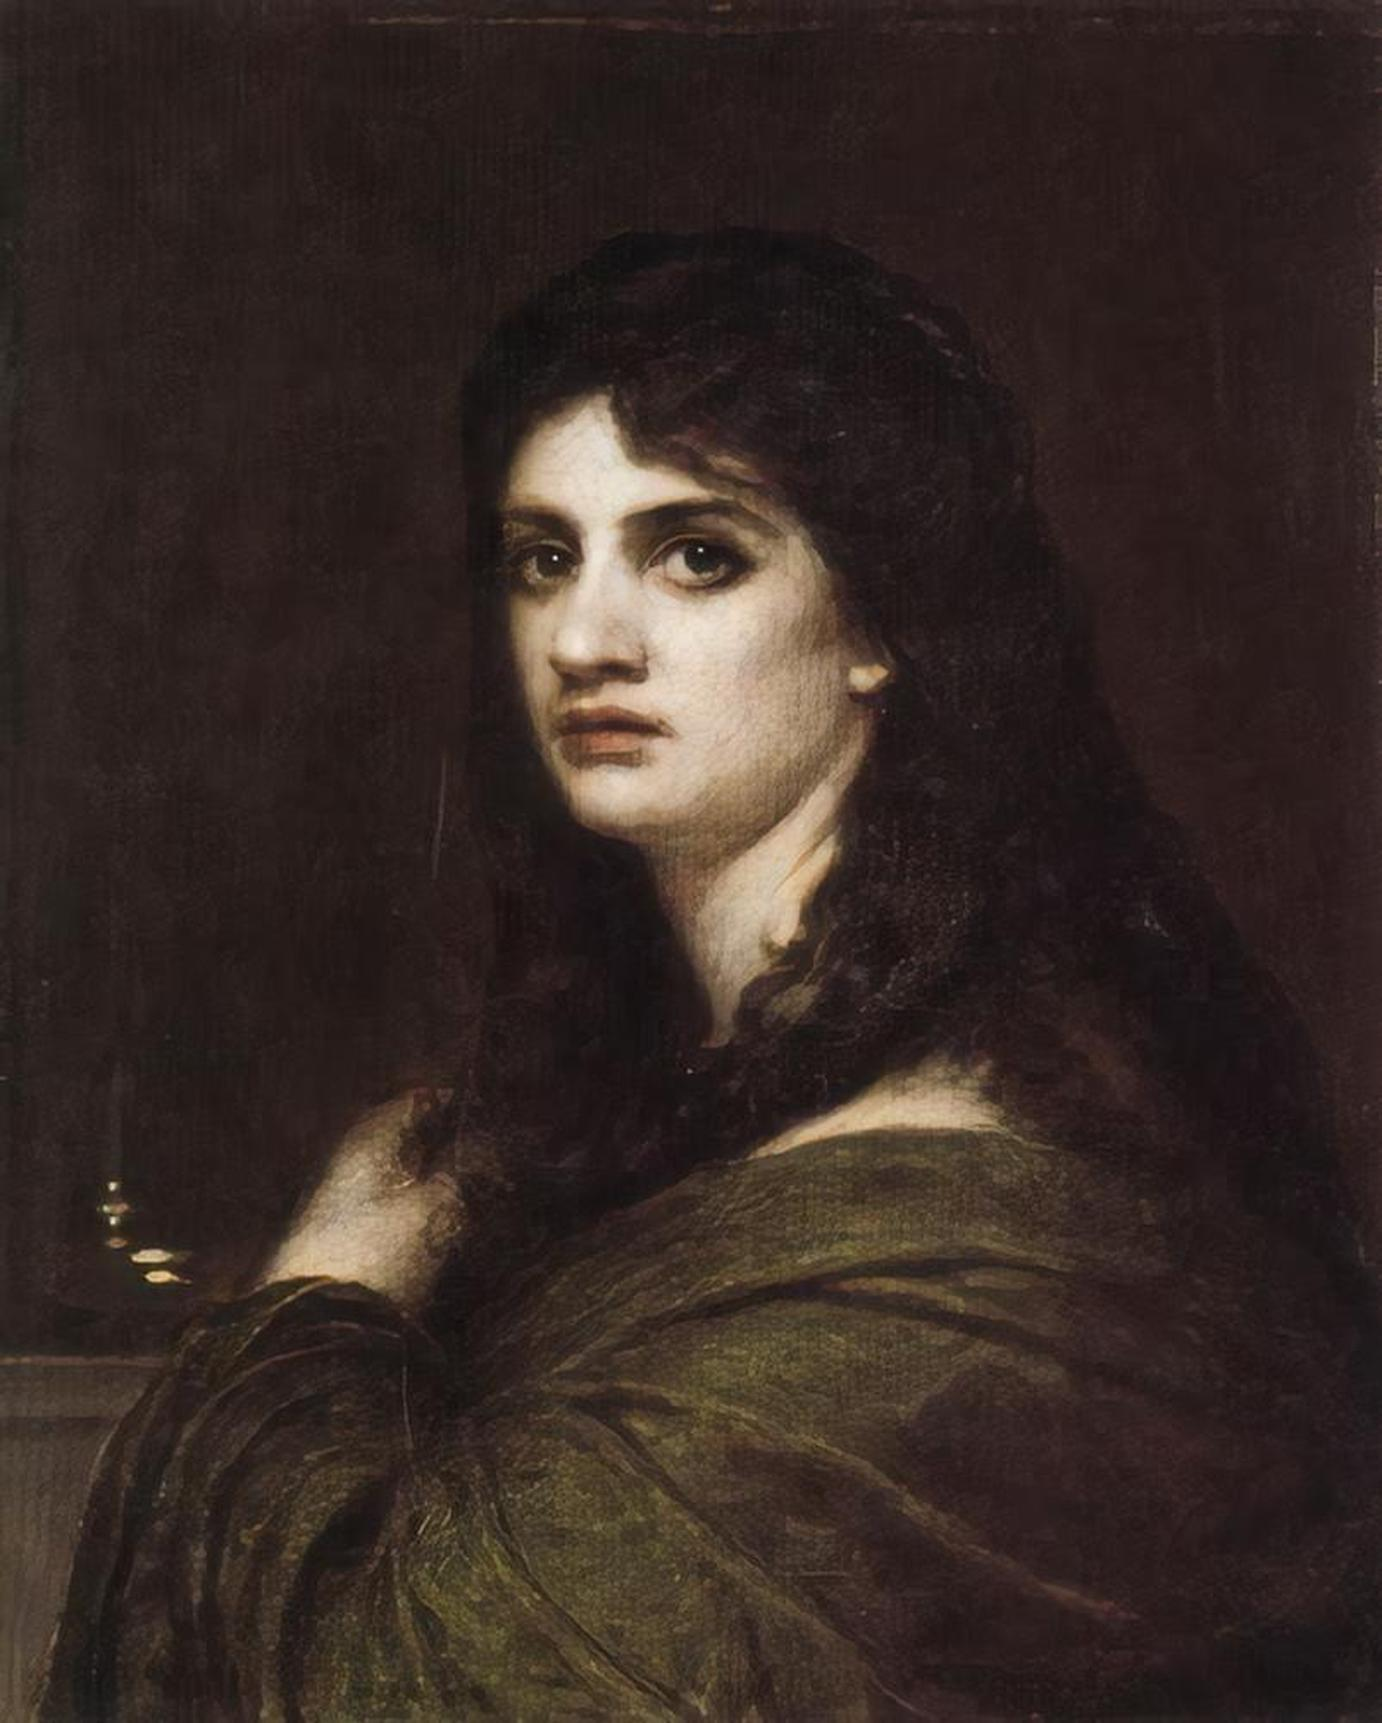

generated captions: 
two women smile for the camera
two women smile for picture
two women smile for the camera while another male watches




In [ ]:
from IPython.display import Image, display
for name in caps.keys():
  act_name = name.split('_')[1]
  print('actual name: ', act_name)
  display(Image('/content/drive/MyDrive/paintings/wikiart/test/flikr/{}'.format(name), width=300, height=300))
  print('generated captions: ')
  for descr in caps[name]:
    print(descr)
  print('\n')
# display(Image('/content/drive/MyDrive/paintings/wikiart/test/flikr/arnold-bГЈВ¶cklin_melancholy.jpg',width=300, height=300))